<a href="https://colab.research.google.com/github/mx60s/predictive-coding-thesis/blob/north-facing/LatentAnalyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze latent variables for head dir, shifters, etc

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 11.5 MB/s eta 0:00:00


In [ ]:
%cd /content/gdrive/MyDrive/thesis/predictive-coding-thesis/src

import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

/content/gdrive/MyDrive/thesis/predictive-coding-thesis/src


In [ ]:
torch.manual_seed(321)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd

Using cuda device
/content/gdrive/MyDrive/thesis/predictive-coding-thesis/src


### Generate latents, post prediction (at least for non-autoencoder) for all samples

In [ ]:
use_headings = True
predictions = True    # if we want to get predictive latents

# I still need to work on the non-predictive because that's messed up with the headings right now
# I'd need to retrain the predictive coder model so that the displacements are not futuristic + added disp at end

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
])

data_dir = 'data/noisy'

if predictions:
    if use_headings:
        dataset = HeadingPredCoordDataset(source_directory=data_dir, seq_len=7, transform=transform)
    else:
        dataset = SequentialFrameDataset(source_directory=data_dir, seq_len=7,
                                         transform=transform)
else:
    dataset = AutoencoderDataset(source_directory=data_dir, transform=transform)


print(f'{len(dataset)} samples')

batch_size = 16 if predictions else 64
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

107937 samples


In [ ]:
%ls /content/gdrive/MyDrive/thesis/predictive-coding-thesis/src/model_files

faceforward_88143_samples-200ep-causal.pt
faceforward_noisy_83143_samples-200ep-causal-partial.pt
faceforward_noisy_83143_samples-200ep-causal.pth
faceforward_noisy_97143_samples-200ep-causal.pt
facenorth_71884_samples-200ep-causal_predictor.pt


In [ ]:
if use_headings:
    model_file = 'faceforward_88143_samples-200ep-causal.pt'
    model = PredictiveCoderWithHead()
else:
    model_file = 'facenorth_71884_samples-200ep-causal_predictor.pt'
    model = PredictiveCoder()

model.to(device)
model.load_state_dict(torch.load('model_files/' + model_file))
model.eval()
for param in model.parameters():
    param.requires_grad = False


In [ ]:
seq, pred = next(iter(loader))
frames, heading = seq
print(heading)
print(pred)

tensor([[  0.,   0.,   0., -90.,   0., -90., -90.],
        [  0.,   0., -90.,   0., -90., -90.,   0.],
        [  0., -90.,   0., -90., -90.,   0.,   0.],
        [-90.,   0., -90., -90.,   0.,   0.,   0.],
        [  0., -90., -90.,   0.,   0.,   0.,  90.],
        [-90., -90.,   0.,   0.,   0.,  90.,   0.],
        [-90.,   0.,   0.,   0.,  90.,   0.,   0.],
        [  0.,   0.,   0.,  90.,   0.,   0.,   0.],
        [  0.,   0.,  90.,   0.,   0.,   0.,   0.],
        [  0.,  90.,   0.,   0.,   0.,   0.,   0.],
        [ 90.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,  90.]])
tensor([[-448.5000, -673.5000,  180.0000],
        [-448.5000, -674.5000,  180.0000],
        [-448.5000, -675.5000,  180.0000],
        [-448.5000, -676.5000,  180.00

In [ ]:
latent_preds = []
pred_coords = []

latent_save_file = f'data/latents/predictive-{model_file[:-3]}.npy'
pred_coords_save_file = f'data/latents/coords-predictive-{model_file[:-3]}.npy'

with torch.no_grad():
    for seq, pred in loader:
        if use_headings:
            frames, headings = seq[0].to(device), seq[1].to(device)
            latents = model.get_latent_preds(frames, headings)
        else:
            frames = seq.to(device)
            latents = model.get_latent_preds(frames)

        latent_preds.append(latents.cpu().numpy())
        pred_coords.append(pred.numpy())

latents_unrolled = np.concatenate(latent_preds, axis=0)
preds_unrolled = np.concatenate(pred_coords, axis=0)

np.save(latent_save_file, latents_unrolled)
np.save(pred_coords_save_file, preds_unrolled)

### Run t-SNE on latent variables

In [ ]:
model_file = 'faceforward_88143_samples-200ep-causal.pt'

latent_save_file = f'data/latents/predictive-{model_file[:-3]}.npy'
pred_coords_save_file = f'data/latents/coords-predictive-{model_file[:-3]}.npy'

latents = np.load(latent_save_file)
pred_coords = np.load(pred_coords_save_file)

In [ ]:
! pip install numpy matplotlib scikit-learn pandas

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE

df = pd.DataFrame(pred_coords, columns=['x', 'y', 'yaw'])

subset_indices = np.random.choice(latents.shape[0], 40000, replace=False)
latents_subset = latents[subset_indices]
df_subset = df.iloc[subset_indices]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=2000, random_state=42)
tsne_results = tsne.fit_transform(latents_subset)

<ipython-input-16-a26dcf881266>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['xy_magnitude'] = np.sqrt(df_subset['x']**2 + df_subset['y']**2)


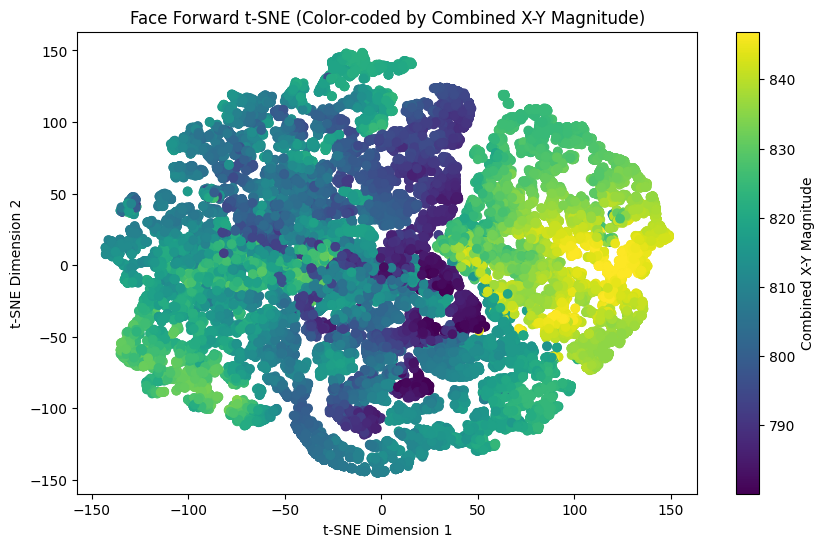

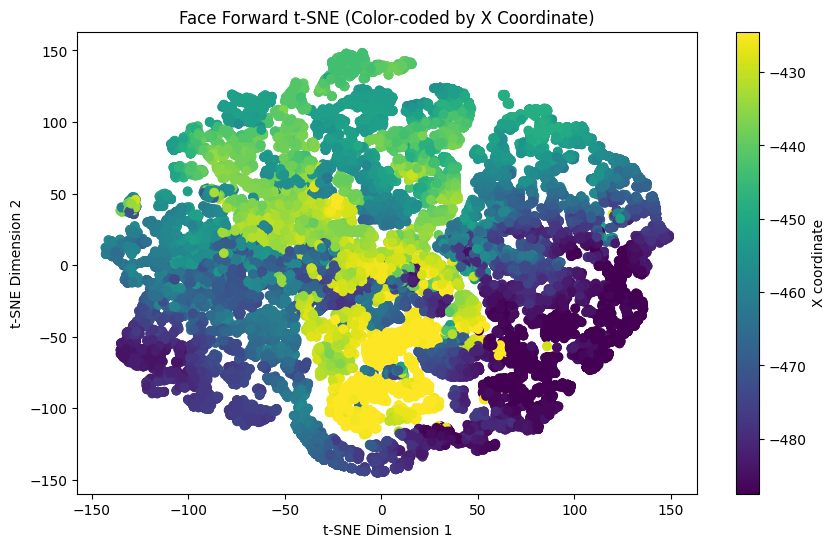

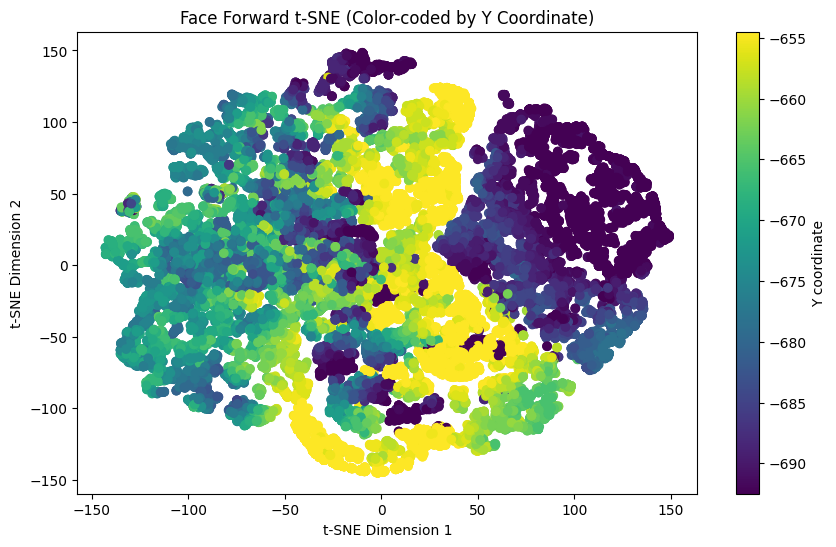

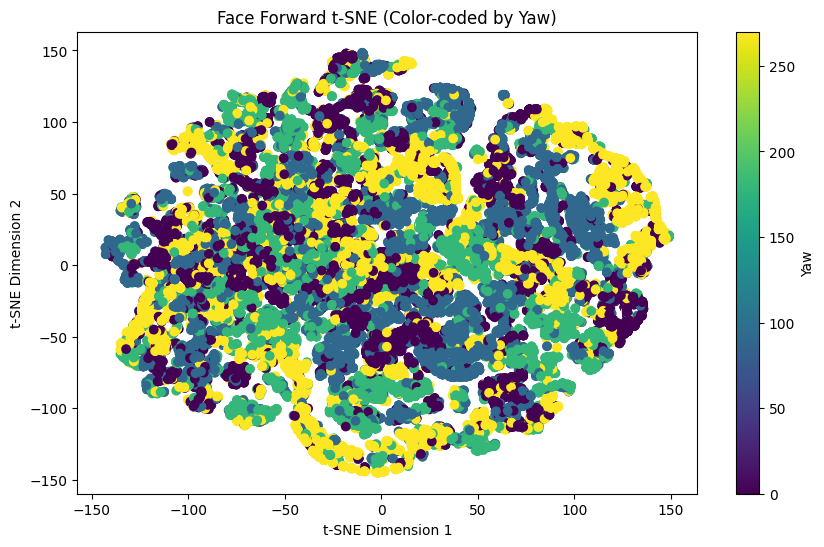

In [ ]:
df_subset['xy_magnitude'] = np.sqrt(df_subset['x']**2 + df_subset['y']**2)

plt.figure(figsize=(10, 6))
# Use the 'xy_magnitude' column for coloring
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_subset['xy_magnitude'], cmap='viridis')
plt.colorbar(sc, label='Combined X-Y Magnitude')
plt.title('Face Forward t-SNE (Color-coded by Combined X-Y Magnitude)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

plt.savefig('face-forward-tsne-xy.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()

plt.figure(figsize=(10, 6))
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_subset['x'], cmap='viridis')
plt.colorbar(sc, label='X coordinate')
plt.title('Face Forward t-SNE (Color-coded by X Coordinate)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
plt.savefig('face-forward-tsne-x.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()

plt.figure(figsize=(10, 6))
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_subset['y'], cmap='viridis')
plt.colorbar(sc, label='Y coordinate')
plt.title('Face Forward t-SNE (Color-coded by Y Coordinate)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
plt.savefig('face-forward-tsne-y.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()

plt.figure(figsize=(10, 6))
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_subset['yaw'], cmap='viridis')
plt.colorbar(sc, label='Yaw')
plt.title('Face Forward t-SNE (Color-coded by Yaw)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
plt.savefig('face-forward-tsne-yaw.png', dpi=300)  # Saves the plot as a PNG file with 300 DPI
plt.close()


## PCA analysis

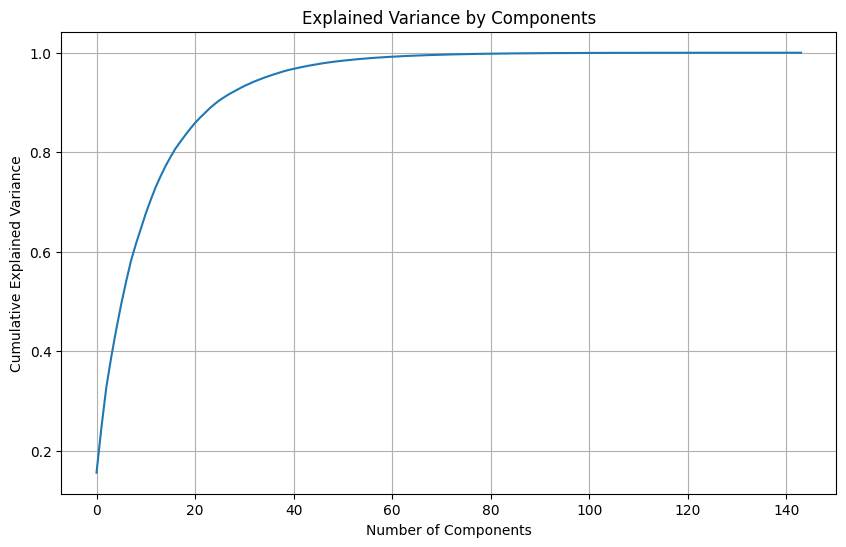

Number of components to keep for 95% variance: 36


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
latents_standardized = scaler.fit_transform(latents_subset)

pca = PCA()
pca.fit(latents_standardized)

latents_pca = pca.transform(latents_standardized)

# Step 6: Examine the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Decide the number of components to keep and transform the data
# For example, to keep 95% of variance, find where cumulative explained variance reaches 0.95
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0] + 1
print(f"Number of components to keep for 95% variance: {n_components}")

# Re-run PCA with the desired number of components
pca = PCA(n_components=n_components)
latents_pca_reduced = pca.fit_transform(latents_standardized)

# Now, 'latents_pca_reduced' is your dataset transformed to the principal component space with reduced dimensionality
